# 1. Install Dependencies and Setup

In [1]:
!pip install tensorflow opencv-python matplotlib

In [91]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

# 2. Load Data

### 2.1 Load Images

In [92]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [93]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [94]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [95]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

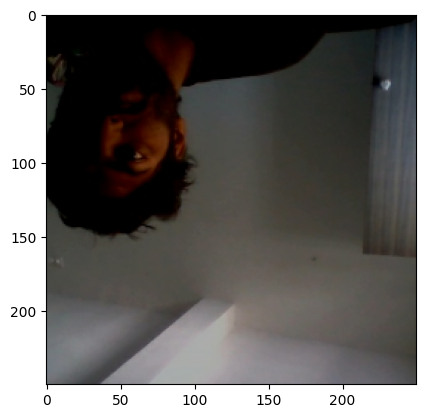

In [96]:
plt.imshow(val_images.as_numpy_iterator().next())

### 2.2 Prepare Labels

In [97]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoints']]

In [98]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float32]))

In [99]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float32]))

In [100]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float32]))

In [101]:
val_labels.as_numpy_iterator().next()

(array([0.08977778, 0.3351111 , 0.23555556, 0.37422222], dtype=float32),)

### 2.3. Combine Labels and Images

In [102]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000)
train = train.batch(16)
train = train.prefetch(4)

In [103]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(2200)
test = test.batch(16)
test = test.prefetch(4)

In [104]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(16)
val = val.prefetch(4)

In [105]:
len(train_images)

6720

### 2.4 View Samples

In [106]:
data_samples = train.as_numpy_iterator()

In [107]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


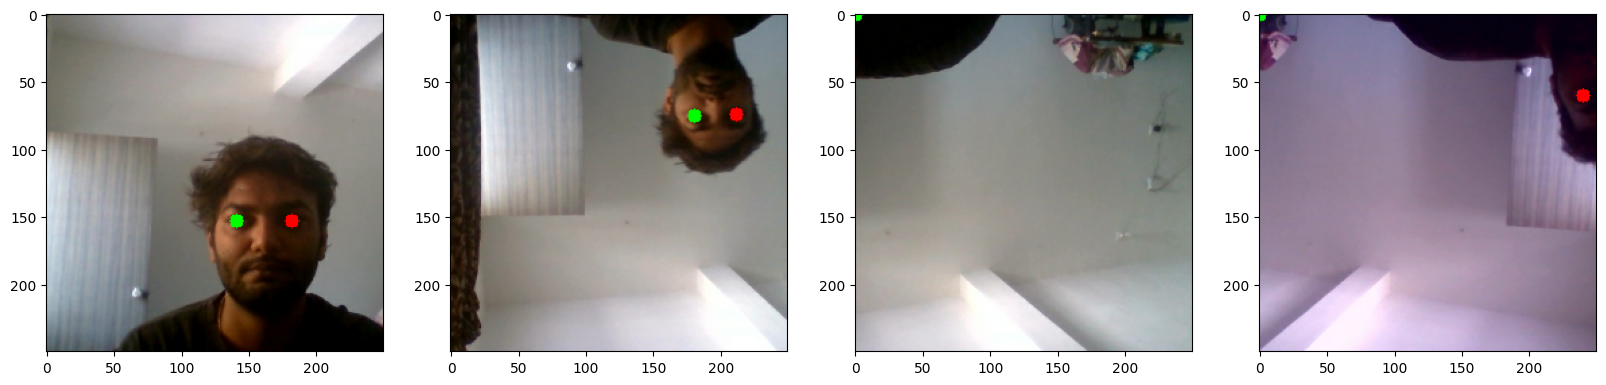

In [108]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][0][idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 5, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 5, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# 3. Build Model

### 3.1 Create Neural Network

In [109]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [110]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((4,))
])

In [111]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet152v2 (Functional)             │ (None, 8, 8, 2048)          │      58,331,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 8, 8, 512)           │       9,437,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 4, 4, 256)           │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 2, 2, 256)           │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 1, 1, 4)             │           4,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,575,556 (273.04 MB)

 Trainable params: 71,431,812 (272.49 MB)

 Non-trainable params: 143,744 (561.50 KB)

### 3.2 Setup Losses and Optimizer

In [112]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()

In [113]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [114]:
X, y = train.as_numpy_iterator().next()

In [115]:
X.shape

(16, 250, 250, 3)

In [116]:
coordinates = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 19s 19s/step


In [117]:
coordinates

array([[ 0.20530826,  0.7387173 , -0.02422158,  0.31669998],
       [-0.3406152 ,  0.6251733 ,  0.38401306,  0.46446902],
       [-0.01456967,  0.6253841 ,  0.12578735,  0.03704349],
       [-0.734271  ,  0.8741269 , -0.17544505,  1.4055212 ],
       [ 0.07145323,  0.3367712 , -0.13353643,  0.7428814 ],
       [-0.7307117 ,  0.8255315 ,  0.09541506,  0.18544252],
       [ 0.17482048,  0.62736535,  0.3198098 ,  0.76555413],
       [ 0.02721436,  0.4453854 ,  0.05395138,  0.88507104],
       [ 0.23359235,  0.5593585 ,  0.14923131,  1.1594937 ],
       [ 0.04847147,  0.8125999 ,  0.16140077,  0.57943845],
       [-0.23041049,  0.8402205 ,  0.37994206,  0.5002855 ],
       [ 0.56214255,  1.1048751 , -0.00241079,  0.08398224],
       [-0.01352465,  0.7992766 ,  0.10072917,  0.40452236],
       [-0.28150818,  0.4486604 , -0.31148493,  0.5994967 ],
       [ 0.14856052,  0.42787606, -0.06553991,  0.52532625],
       [-0.01834588,  0.18666464, -0.14037463,  0.6353403 ]],
      dtype=float32)

### 3.4 Train the Model

In [118]:
# Train for 100 epochs
hist = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5


ValueError: Cannot take the length of shape with unknown rank.

# 4. Review Performance

### 4.1 View Loss Plots

In [ ]:
hist.history

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = model.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### 4.3. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('eyetrackerresnet.h5')

In [ ]:
model = load_model('eyetrackerresnet.h5')

In [ ]:
model.predict(test_sample[0])

# 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()